## Time series with time structured parameters and summary statistics

Idea: construct a model $p(x|\theta)$ with $\theta = (\theta_1,...\theta_n)$ and summary statistics $s(x) = (s_1(x),...s_m(x))$ s.t.


for all $i$ there exists a $j$, $j\leq m$, and $l$, $j\leq l$ such that
 
$p(s_{1:i}|\theta_{1:n} ) = p(s_{1:i}|\theta_{1:j}) $.

and 

$p(s_{1:i+1}|\theta_{1:n} ) = p(s_{1:i+1}|\theta_{1:l}) $.

### Examples:
1. Piecewise linear function:
 - $\theta_{1,2}$ : a and b of linear function f(x) = ax + b
 - $\theta_{3,4}$ : time of changing point cp, and a2 of second slope

 2. Sinusoidal waves with linearly increasing/decreasing amplitudes, and changing points at which this linear function changes.
 


In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt


import sys
sys.path.append('../code/')
import os

import torch

#from utils.helpers import get_time

from utils.sbi_modulated_functions import Combined


from utils.helpers import get_time

In [2]:
# sbi


from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.inference import SNPE_C



## Piecewise_linear() and simulation wrappers for SBI

I defined a seperate function for each sequential step such that we can vary different numbers of parameters

In [3]:
start = get_time()



def piecewise_linear(a1,b, a2,a3, cp1, cp2, add_noise=None):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    if not add_noise == None:
        a1,b, a2,a3, cp1, cp2 = np.array([a1,b, a2,a3, cp1, cp2]) + scp.random.normal(scale=add_noise,size=6)       
    
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    
    # first piece
    y[x<cp1] = (b+a1*x[x<cp1])
    
    # second piece     
    y[(x>=cp1) & (x<cp2)] = y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
    # third piece
    y[x>=cp2] = y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    

    return y


def piecewise_linear_seq(thetas):
    """
    I defined a seperate function for each sequential step such that we can vary different numbers of parameters
    Args:
        a1 (float): first slope
        b (float): offset
        a2 (float): second slope
        a3 (float): 3rd slope
        cp1, cp2 (float): changing points
        add_noise (None or float): None or scale of Gaussian noise on all variables

    Returns:
        x,y (arrays): x and y of piecewise linear function. 
    """
    
    add_noise=0.2
    
    cp1 = np.float32(3)
    cp2 = np.float32(6)
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    
    
    if (len(thetas)==2):
        a1 = thetas[0]
        b = thetas[1]
        
        if not add_noise == None:
            a1,b = np.array([a1,b]) + scp.random.normal(scale=add_noise,size=2)  
            
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
        
        return y[x<cp1]
    
     
    if (len(thetas)==3):     
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        
        if not add_noise == None:
            a1,b, a2 = np.array([a1,b, a2]) + scp.random.normal(scale=add_noise,size=3)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
        
        return y[x<cp2]
    
    
    if (len(thetas)==4):
        
        
        a1 = thetas[0]
        b = thetas[1]
        a2 = thetas[2]
        a3 = thetas[3]
        
        if not add_noise == None:
            a1,b, a2, a3 = np.array([a1,b, a2, a3]) + scp.random.normal(scale=add_noise,size=4)       
    
        # first piece
        y[x<cp1] = (b+a1*x[x<cp1])
    
        # second piece     
        y[(x>=cp1) & (x<cp2)] = y[torch.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)]  - cp1) 
    
        # third piece
        y[x>=cp2] = y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
        
        return y

### Define prior and summary stats dependent on prior

In [4]:
"""
Priors
"""

b = scp.random.uniform(0,10)
a1 = scp.random.uniform(-10,0)
a2 = scp.random.uniform(0,10)
a3 = scp.random.uniform(-10,0)
cp1 = scp.random.uniform(2,4)
cp2 = scp.random.uniform(5,8)


x = piecewise_linear(a1,b, a2,a3, cp1, cp2)



**Summary statistics**

I defined a few more summary statistics such that we have 13 in total.

In [40]:
"""
Summary stats
"""

def extract_sumstats(y):
    """
    Extract some sumstats for piecewise linear fct with specified prior 
    !the information in the sumstats is highly dependent on the prior!
    Args:
        x ([array]): time axis of time series
        y ([array]): 1d time series
        max_time (float, optional): maximal time to calculate sumstats on. Defaults to 10.

    Returns:
       s [array]: summary stats of time series, with np.nan for non-calculated sumstats
    """
    
    max_time = 10
    
    batch_list = []
    # first batch of sumstats for times <4
    
    for batch in y:
        
        #print(len(batch))
        
        #print(batch)
        
        step_size = max_time/len(batch)
        
        
        x = torch.arange(0, max_time, step_size, dtype=torch.float64)
        
        
        
        
        batch[x>max_time] = np.nan
        s = []
        
        s.append(np.float32(batch[0]))    #offset
        s.append(np.nanmin(batch[x<4]))   # local min
        
        #print(type(s[0]), type(s[1]))
        s.append(np.nanargmin(batch[x<4]))   #value of min
    

        # second batch of sumstats for times > 4
        if len(batch) > 300 :
            s.append(np.nanmax(batch[(x>=4)&(x<8)]))
            s.append(np.nanmin(batch[(x>=4)&(x<8)]))
            s.append(np.nanargmin(batch[(x>=4)&(x<8)]))

        # third batch of sumstats for times > 5
        if len(batch) > 600:
            s.append(np.nanmin(batch[x>=5]))
            s.append(np.nanargmin(batch[x>=5]))
            
            s.append(np.nanmax(batch[x>=5]))
            s.append(np.nanargmax(batch[x>=5]))
            
        s = np.float32(s)
    
            
        batch_list.append(torch.from_numpy(s))

    return torch.stack(batch_list)


## cosine waves

WORK IN PROGRESS

same, but more ellaborated summary stats are needed

In [41]:
def cosine_waves(a1,b,a2,cp,f_1=1, f_2=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset (starting amplitude)
        a2 (float): second slope
        cp (float): changing point
        f_1 (float): first freq
        f_2 (float): second freq

    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp])
    factor1[factor1<0] = 0
    y[x<cp] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp])
     
    factor2= y[np.sum(x<cp)-1] + a2* (x[x>=cp] - cp) 
    factor2[factor2<0] = 0

    y[x>=cp] = (factor2) * np.cos(2*np.pi * f_2 * x[x>=cp]) 

    if return_factors:
        return x,y, factor1, factor2
    else:
        return x,y

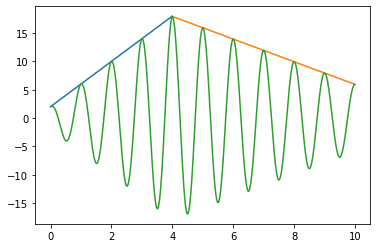

In [42]:
x,y,f1,f2=cosine_waves(4,2,-2,4, return_factors=True  )

plt.plot(x[:len(f1)],f1)
plt.plot(x[-len(f2):],f2)
plt.plot(x,y)

In [43]:
def cosine_waves_2(a1,b,a2,a3, cp1, cp2, f_1=1, f_2=1,f_3=1, return_factors=False):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    x = np.arange(0,10,0.01)
    y = np.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[np.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y
    
    
def cosine_waves_2_first(thetas):
    """
    Args:
        a1 (float): first slope
        b (float): offset
        ai (float): slopes
        cpi (float): changing points
        f_i (float): first freqs
        
    Returns:
        [type]: [description]
    """
    
    a1 = thetas[0]
    b = thetas[1]
    a2=-3
    a3=3
    cp1=2
    cp2=6
    f_1=1
    f_2=1
    f_3=1
    
    return_factors=False
    
    x = torch.arange(0,10,0.01, dtype= torch.float32)
    y = torch.zeros(x.shape)
    factor1 = (b+a1*x[x<cp1])
    factor1[factor1<0] = 0
    y[x<cp1] = factor1 * np.cos(2*np.pi * f_1 * x[x<cp1])
     
    factor2= y[np.sum(x<cp1)-1] + a2* (x[(x>=cp1) & (x<cp2)] - cp1) 
    factor2[factor2<0] = 0
    y[(x>=cp1) & (x<cp2)] = (factor2) * np.cos(2*np.pi * f_2 * x[(x>=cp1) & (x<cp2)]) 
    
    factor3= y[torch.sum(x<cp2)-1] + a3* (x[x>=cp2] - cp2) 
    factor3[factor3<0] = 0

    y[x>=cp2] = (factor3) * np.cos(2*np.pi * f_3 * x[x>=cp2]) 

    if return_factors:
        return x,y, factor1, factor2, factor3
    else:
        return x,y

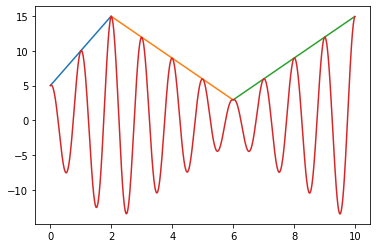

In [44]:
x,y,f1,f2,f3=cosine_waves_2(5,5,
                            -3,3,
                            2,6, return_factors=True)

plt.plot(x[:len(f1)],f1)
plt.plot(x[len(f1):-len(f3)],f2)
plt.plot(x[-len(f3):],f3)

plt.plot(x,y)

## Sequential Time Series SBI


We have the follwoing parameters: a1,b,a2,a3, cp1, cp2

Let's assume this ground truth: true_params = $[5, 5, -3, 2, 1, 5]$

and the following uniform priors: 

prior_min = $[3, 3, -5, 0, -1, 3]  $

prior_max = $[7, 7, -1, 4, 3, 7]$


We start with inferring the first 2 parameters (a1, b), therefore call the function $piecewise_linear_first_batch()$
that only varies these 2 parameters within the prior range.

In [45]:
#parameter a1,b,a2,a3, cp1, cp2



prior_min = [3, 3, -5, 0]  

prior_max = [7, 7, -1, 4]



In [46]:
import datetime

In [47]:
start = datetime.datetime.now()

## Without rounds - no sequential approach!


In [48]:
num_rounds = 3
num_simulations= 300

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)


density_estimator = 'mdn'



posteriors = []
proposal = prior


true_params = [5, 5, -3, 2]
obs_real = piecewise_linear_seq(true_params)


x_o = extract_sumstats([obs_real])[0]
print(x_o)

simulator_stats, prior = prepare_for_sbi(piecewise_linear_seq, prior)
inference = SNPE_C(prior, density_estimator='mdn')

for _ in range(num_rounds):

    theta, x_without = simulate_for_sbi(
        simulator_stats,
        proposal=proposal,
        num_simulations=num_simulations,
        num_workers=4,
    )
    
    x = extract_sumstats(x_without)
    
    print('x', x)

     # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

tensor([  4.7327,   4.7327,   0.0000,  17.2825,  11.3328, 199.0000,  11.3328,
         99.0000,  19.2333, 499.0000])


/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:66: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

x tensor([[  4.9094,   4.9094,   0.0000,  ...,  99.0000,  14.8332, 499.0000],
        [  4.8219,   4.8219,   0.0000,  ...,  99.0000,  19.9372, 499.0000],
        [  3.6296,   3.6296,   0.0000,  ...,  99.0000,  17.0617, 499.0000],
        ...,
        [  4.0455,   4.0455,   0.0000,  ...,  99.0000,  13.5012, 499.0000],
        [  5.6335,   5.6335,   0.0000,  ...,  99.0000,  19.7779,   0.0000],
        [  3.1595,   3.1595,   0.0000,  ...,  99.0000,  18.6066, 499.0000]])
Changed epsilon in mdn.py (pyknos) file to:  0.05
Neural network successfully converged after 135 epochs.


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

acceptance rate:  0.9533333333333334
acceptance rate:  0.9706796116504854


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

x tensor([[  4.7975,   4.7975,   0.0000,  ...,  99.0000,  20.8105, 499.0000],
        [  4.6687,   4.6687,   0.0000,  ...,  99.0000,  20.9091, 499.0000],
        [  4.8395,   4.8395,   0.0000,  ...,  99.0000,  22.8067, 499.0000],
        ...,
        [  4.8858,   4.8858,   0.0000,  ...,  99.0000,  17.6645, 499.0000],
        [  5.2863,   5.2863,   0.0000,  ...,  99.0000,  15.9402, 499.0000],
        [  4.6343,   4.6343,   0.0000,  ...,  99.0000,  16.3421, 499.0000]])
Using SNPE-C with non-atomic loss
Neural network successfully converged after 32 epochs.


Drawing 300 posterior samples:   0%|          | 0/300 [00:00<?, ?it/s]

acceptance rate:  0.8766666666666667
acceptance rate:  0.8806796116504855


Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

x tensor([[  3.8474,   3.8474,   0.0000,  ...,  99.0000,  16.7878, 499.0000],
        [  4.3304,   4.3304,   0.0000,  ...,  99.0000,  17.8386, 499.0000],
        [  4.5128,   4.5128,   0.0000,  ...,  99.0000,  18.0089, 499.0000],
        ...,
        [  5.1277,   5.1277,   0.0000,  ...,  99.0000,  22.6471, 499.0000],
        [  4.3902,   4.3902,   0.0000,  ...,  99.0000,  16.9522, 499.0000],
        [  3.7247,   3.7247,   0.0000,  ...,  99.0000,  17.0850, 499.0000]])
Using SNPE-C with non-atomic loss
Neural network successfully converged after 43 epochs.


In [49]:
finish = datetime.datetime.now()

time = finish - start

print(time)

0:00:12.883730


Next, we sample from posterior and from prior

In [57]:
num_samples = 1000

samples = posterior.sample((num_samples,), x=x_o)

samples_prior = []
for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

acceptance rate:  0.909
acceptance rate:  0.9059090909090909


In the following cell, we get observations based on the posterior and the prior samples:

In [58]:
from joblib import Parallel, delayed

num_workers = 4
x_lin = torch.arange(0,10,0.01, dtype= torch.float32)
s_x = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples)


s_x_prior = Parallel(
        n_jobs=num_workers,
        verbose=0,
        pre_dispatch="1.5*n_jobs",
        backend="multiprocessing",
    )(delayed(piecewise_linear_seq)(sample) for sample in samples_prior)

Next, we extract the summary statistics of the observations which are based on the posterior and prior samples. This allows to later compare the histograms of the summary statistics and evaluate if the true parameters are well represented within the posterior!

In [59]:
s_x_stat = extract_sumstats(s_x)

s_x_prior_stat = extract_sumstats(s_x_prior)



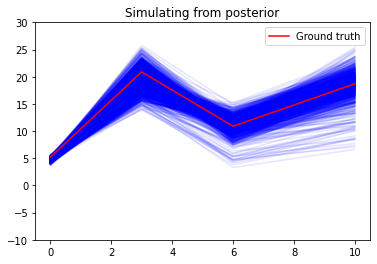

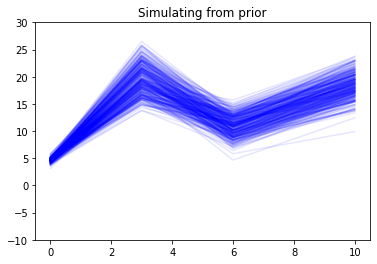

In [60]:
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from posterior")
for s in s_x:
    im = plt.plot(x_lin, s, alpha=0.1, color='blue')
    plt.ylim(-10,30)
plt.plot(x_lin, obs_real, label='Ground truth', color='red')
plt.legend()
    
    
    
fig, ax = plt.subplots(1, 1)
ax.set_title("Simulating from prior")
for x_w in x_without:
    plt.plot(x_lin, x_w, alpha=0.1, color='blue')

    plt.ylim(-10,30)


    

In [61]:
true_params

tensor([[ 5,  5, -3,  2,  1,  5]])

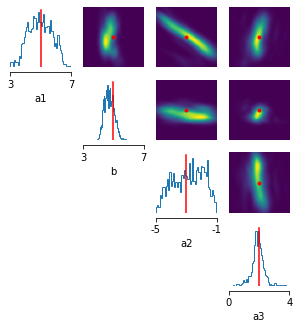

In [62]:
limits = [list(tup) for tup in zip(prior_min, prior_max)]

true_params = torch.tensor([5, 5, -3, 2])

parameter_names = ['a1', 'b', 'a2', 'a3']

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=limits,
    upper = 'kde',
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    #tick_labels=parameter_names
    labels=parameter_names,
)

In [38]:
true_params.size(dim=0)

1

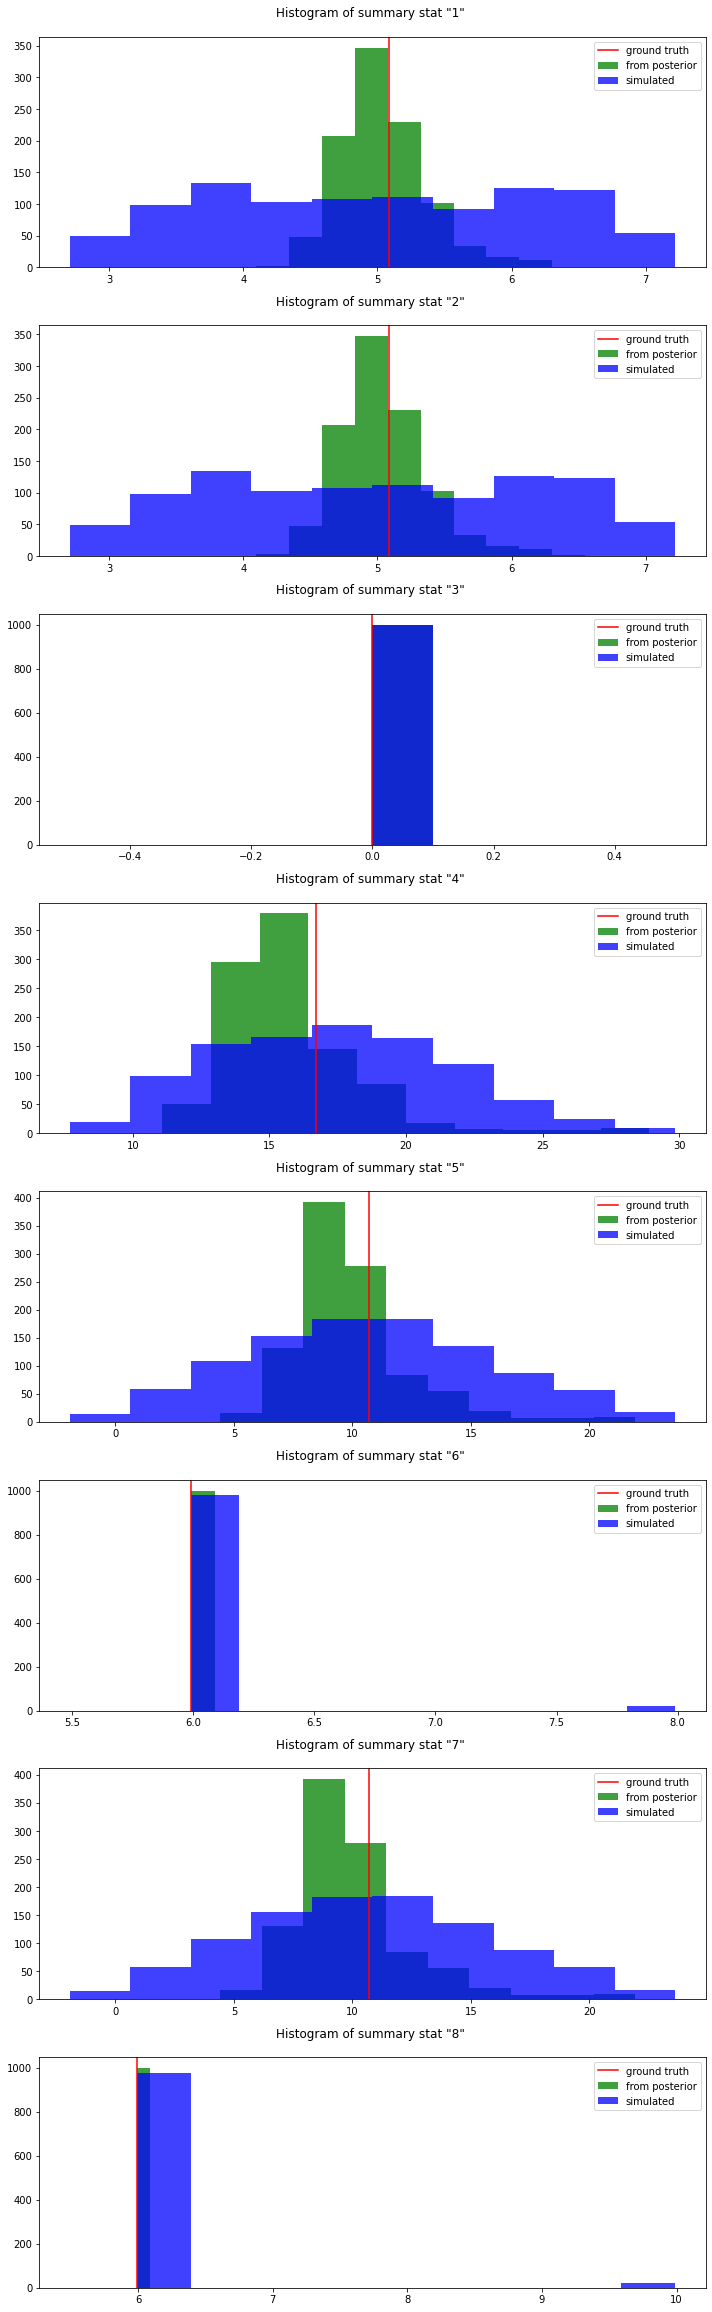

In [39]:
import matplotlib.gridspec as gridspec



fig = plt.figure(figsize=(10,40), tight_layout=True)

gs = gridspec.GridSpec(nrows=x.size(dim=1), ncols=1)


sum_stats_names = torch.arange(1, len(s_x_stat[0]), 1)





#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)-1):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)-1):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])



    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=False, facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=False, facecolor='b', alpha=0.75, histtype='barstacked', label='simulated')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stats[i], color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')





plt.savefig('Summary_stats_post_prior')